**Train Random Forest Model**

1. import Python packages and training data

In [1]:
# adding required libraries
import pandas as pd
import numpy as np

In [2]:
# Load the data from csv
x_data_org =pd.read_csv('../data/interim/x_data_org.csv')
y_data_org =pd.read_csv('../data/interim/y_data_org.csv')
x_data_eda =pd.read_csv('../data/interim/x_data.csv')
y_data_eda =pd.read_csv('../data/interim/y_data.csv')
x_balanced_data =pd.read_csv('../data/interim/x_balanced_data.csv')
y_balanced_data =pd.read_csv('../data/interim/y_balanced_data.csv')

x_test_org =pd.read_csv('../data/interim/x_test_org.csv')
y_test_org =pd.read_csv('../data/interim/y_test_org.csv')
x_test_eda =pd.read_csv('../data/interim/x_test.csv')
y_test_eda =pd.read_csv('../data/interim/y_test.csv')
x_balanced_test =pd.read_csv('../data/interim/x_balanced_test.csv')
y_balanced_test =pd.read_csv('../data/interim/y_balanced_test.csv')


2. Train Extra Tree model

In [3]:
from sklearn.ensemble  import ExtraTreesClassifier
et_model = ExtraTreesClassifier(n_estimators=100, random_state=8)
et_model.fit(x_balanced_data, y_balanced_data.values.ravel())

ExtraTreesClassifier(random_state=8)

In [4]:
print(et_model.score(x_balanced_data, y_balanced_data))
print(et_model.score(x_balanced_test, y_balanced_test))

1.0
0.6035087719298246


5. Perform grid search for optimised parameters

In [5]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_et = {
    'n_estimators': [100, 200, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [4, 8, 16],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
et_model = ExtraTreesClassifier(random_state=8)

# Initialize GridSearchCV
grid_search_et = GridSearchCV(estimator=et_model, param_grid=param_grid_et, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_et.fit(x_balanced_data, y_balanced_data.values.ravel())

# Get the best parameters
best_params = grid_search_et.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}


In [6]:
# Train a new Random Forest model with the best parameters
et_model = ExtraTreesClassifier(**best_params, random_state=8)
et_model.fit(x_balanced_data, y_balanced_data.values.ravel())

ExtraTreesClassifier(max_depth=4, n_estimators=500, random_state=8)

5. Check feature importance

In [9]:
# get feature importance
threshold = 0.05
feature_importance = et_model.feature_importances_
important_features = x_balanced_data.columns[feature_importance >= threshold]
x_filtered = x_balanced_data[important_features]
# display the feature importance
print(important_features)

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', 'FTM', 'FTA', 'OREB', 'REB'], dtype='object')


In [12]:
et_model.fit(x_filtered, y_balanced_data.values.ravel())
print(et_model.score(x_balanced_data[important_features], y_balanced_data))
print(et_model.score(x_balanced_test[important_features], y_balanced_test))

0.6347673397717296
0.6385964912280702


6. Exam the model

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

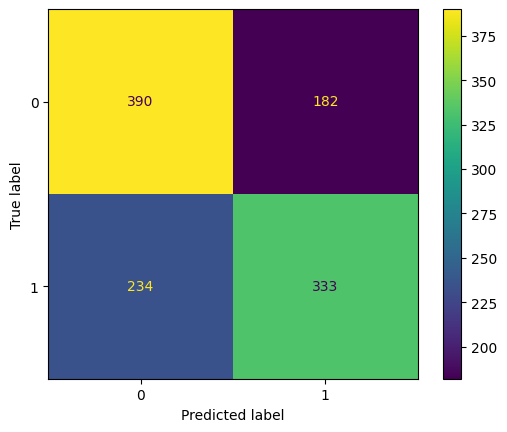

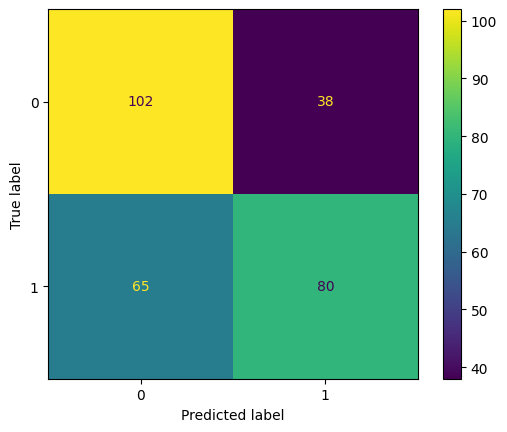

In [14]:
ConfusionMatrixDisplay.from_estimator(et_model, x_balanced_data[important_features], y_balanced_data)
ConfusionMatrixDisplay.from_estimator(et_model, x_balanced_test[important_features], y_balanced_test)

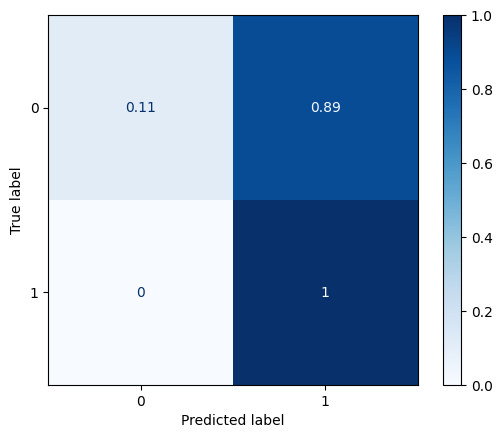

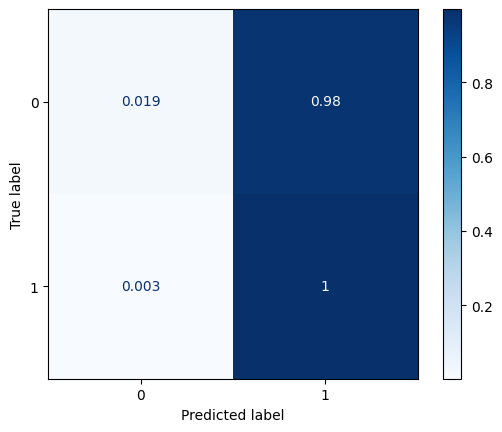

In [21]:
ConfusionMatrixDisplay.from_estimator(et_model, x_data, y_data, cmap=plt.cm.Blues, normalize='true')
ConfusionMatrixDisplay.from_estimator(et_model, x_test, y_test, cmap=plt.cm.Blues, normalize='true')

6. Conclusion
This is a better model compare to SVM model, but the accuracy is not high enough. 

7. Export Model

In [22]:
import joblib

# Export the Random Forest model
joblib.dump(et_model, '../models/et_model.pkl')

['../models/et_model.pkl']